# 03. Cross-Validation 실험

## 목표
- 5-Fold Stratified Cross-Validation으로 모델 일반화 성능 평가
- Out-of-Fold (OOF) 예측으로 과적합 방지
- 폴드별 성능 분석 및 임계값 최적화

## 핵심 개념
- **Stratified K-Fold**: 클래스 비율을 유지하면서 데이터 분할
- **OOF Prediction**: 각 샘플이 validation으로 사용될 때의 예측값 저장
- **CV Score**: 폴드별 점수의 평균과 표준편차로 안정성 평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from catboost import CatBoostClassifier
import sys
sys.path.append('../features')
sys.path.append('../utils')
from feature_engineering import build_a_features, build_b_features
from preprocessing import FeaturePreprocessor

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


## 1. 데이터 로드 및 Feature 생성

In [2]:
# 데이터 로드
print("데이터 로드 중...")
train = pd.read_csv('../data/train.csv')
train_a = pd.read_csv('../data/train/A.csv')
train_b = pd.read_csv('../data/train/B.csv')

print(f"Train shape: {train.shape}")
print(f"클래스 분포: {train['Label'].value_counts(normalize=True)}")

데이터 로드 중...
Train shape: (944767, 3)
클래스 분포: Label
0    0.971123
1    0.028877
Name: proportion, dtype: float64
Train shape: (944767, 3)
클래스 분포: Label
0    0.971123
1    0.028877
Name: proportion, dtype: float64


In [3]:
# Feature 생성
print("\nFeature 생성 중...")
a_features = build_a_features(train_a)
b_features = build_b_features(train_b)

# 병합
train_features = pd.concat([
    train[train['Test'] == 'A'].merge(a_features, on='Test_id', how='left'),
    train[train['Test'] == 'B'].merge(b_features, on='Test_id', how='left')
], ignore_index=True)

print(f"Feature 생성 완료: {train_features.shape}")


Feature 생성 중...
A features built (hybrid): 156 cols | seq_cols=23, scalar_cols=9, time=545.8s
A features built (hybrid): 156 cols | seq_cols=23, scalar_cols=9, time=545.8s
B features built (hybrid): 112 cols | seq_cols=15, scalar_cols=11, time=161.7s
B features built (hybrid): 112 cols | seq_cols=15, scalar_cols=11, time=161.7s
Feature 생성 완료: (944767, 271)
Feature 생성 완료: (944767, 271)


In [4]:
# 전처리
X = train_features.drop(['Test_id', 'Test', 'Label'], axis=1, errors='ignore')
y = train_features['Label']

# 숫자형 컬럼만 선택
X = X.select_dtypes(include=[np.number])
X = X.replace([np.inf, -np.inf], np.nan)

# Preprocessor 적용
preprocessor = FeaturePreprocessor()
X = preprocessor.fit_transform(X)

print(f"\n전처리 후 shape: {X.shape}")
print(f"Target 분포: 양성={y.sum()} ({y.mean():.2%}), 음성={len(y)-y.sum()} ({1-y.mean():.2%})")

전처리: 51개 컬럼 제거 (유효값 부족 또는 상수), 217개 유지

전처리 후 shape: (944767, 217)
Target 분포: 양성=27282 (2.89%), 음성=917485 (97.11%)

전처리 후 shape: (944767, 217)
Target 분포: 양성=27282 (2.89%), 음성=917485 (97.11%)


## 2. 5-Fold Cross-Validation 수행

In [ ]:
# CV 설정
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# 결과 저장용
cv_scores = []
oof_predictions = np.zeros(len(X))
fold_models = []
roc_curves_data = []


5-Fold Stratified Cross-Validation 시작


In [ ]:
# 각 Fold별 학습 및 평가
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n[Fold {fold}/{n_folds}]")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    print(f"  Train: {X_train.shape}, Val: {X_val.shape}")
    print(f"  Train 양성 비율: {y_train.mean():.4f}, Val 양성 비율: {y_val.mean():.4f}")
    
    # 모델 학습
    model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.05,
        depth=6,
        auto_class_weights='Balanced',
        random_seed=42,
        verbose=False
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=20,
        verbose=False
    )
    
    # 예측
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    oof_predictions[val_idx] = y_pred_proba
    
    # 평가
    auc = roc_auc_score(y_val, y_pred_proba)
    
    # 최적 임계값 찾기 (F1 Score 기준)
    thresholds = np.linspace(0.01, 0.5, 50)
    f1_scores = [f1_score(y_val, (y_pred_proba >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    
    print(f"  ROC AUC: {auc:.4f}")
    print(f"  Best Threshold: {best_threshold:.4f} (F1={best_f1:.4f})")
    
    # 결과 저장
    cv_scores.append({
        'fold': fold,
        'auc': auc,
        'best_threshold': best_threshold,
        'best_f1': best_f1,
        'train_size': len(train_idx),
        'val_size': len(val_idx)
    })
    
    fold_models.append(model)
    
    # ROC Curve 데이터 저장
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_curves_data.append({'fold': fold, 'fpr': fpr, 'tpr': tpr, 'auc': auc})


[Fold 1/5]
  Train: (755813, 217), Val: (188954, 217)
  Train 양성 비율: 0.0289, Val 양성 비율: 0.0289
  Train: (755813, 217), Val: (188954, 217)
  Train 양성 비율: 0.0289, Val 양성 비율: 0.0289
  ROC AUC: 0.6402
  Best Threshold: 0.5000 (F1=0.0782)

[Fold 2/5]
  ROC AUC: 0.6402
  Best Threshold: 0.5000 (F1=0.0782)

[Fold 2/5]
  Train: (755813, 217), Val: (188954, 217)
  Train 양성 비율: 0.0289, Val 양성 비율: 0.0289
  Train: (755813, 217), Val: (188954, 217)
  Train 양성 비율: 0.0289, Val 양성 비율: 0.0289
  ROC AUC: 0.6399
  Best Threshold: 0.5000 (F1=0.0787)

[Fold 3/5]
  ROC AUC: 0.6399
  Best Threshold: 0.5000 (F1=0.0787)

[Fold 3/5]
  Train: (755814, 217), Val: (188953, 217)
  Train 양성 비율: 0.0289, Val 양성 비율: 0.0289
  Train: (755814, 217), Val: (188953, 217)
  Train 양성 비율: 0.0289, Val 양성 비율: 0.0289
  ROC AUC: 0.6379
  Best Threshold: 0.5000 (F1=0.0777)

[Fold 4/5]
  ROC AUC: 0.6379
  Best Threshold: 0.5000 (F1=0.0777)

[Fold 4/5]
  Train: (755814, 217), Val: (188953, 217)
  Train 양성 비율: 0.0289, Val 양성 비율: 0.028

## 3. CV 결과 분석

In [ ]:
# 결과 DataFrame
cv_results = pd.DataFrame(cv_scores)
display(cv_results)

# 통계
print(f"\nCross-Validation 통계:")
print(f"  평균 ROC AUC: {cv_results['auc'].mean():.4f} ± {cv_results['auc'].std():.4f}")
print(f"  최소 ROC AUC: {cv_results['auc'].min():.4f}")
print(f"  최대 ROC AUC: {cv_results['auc'].max():.4f}")
print(f"  평균 Best F1: {cv_results['best_f1'].mean():.4f}")

# OOF Score
oof_auc = roc_auc_score(y, oof_predictions)
print(f"\n🎯 Out-of-Fold ROC AUC: {oof_auc:.4f}")

,fold,auc,best_threshold,best_f1,train_size,val_size
0,1,0.640160,0.5,0.078236,755813,188954
1,2,0.639914,0.5,0.078688,755813,188954
2,3,0.637906,0.5,0.077650,755814,188953
3,4,0.637485,0.5,0.077825,755814,188953
4,5,0.631610,0.5,0.077210,755814,188953



📊 Cross-Validation 통계:
  평균 ROC AUC: 0.6374 ± 0.0035
  최소 ROC AUC: 0.6316
  최대 ROC AUC: 0.6402
  평균 Best F1: 0.0779

🎯 Out-of-Fold ROC AUC: 0.6373


## 4. 시각화

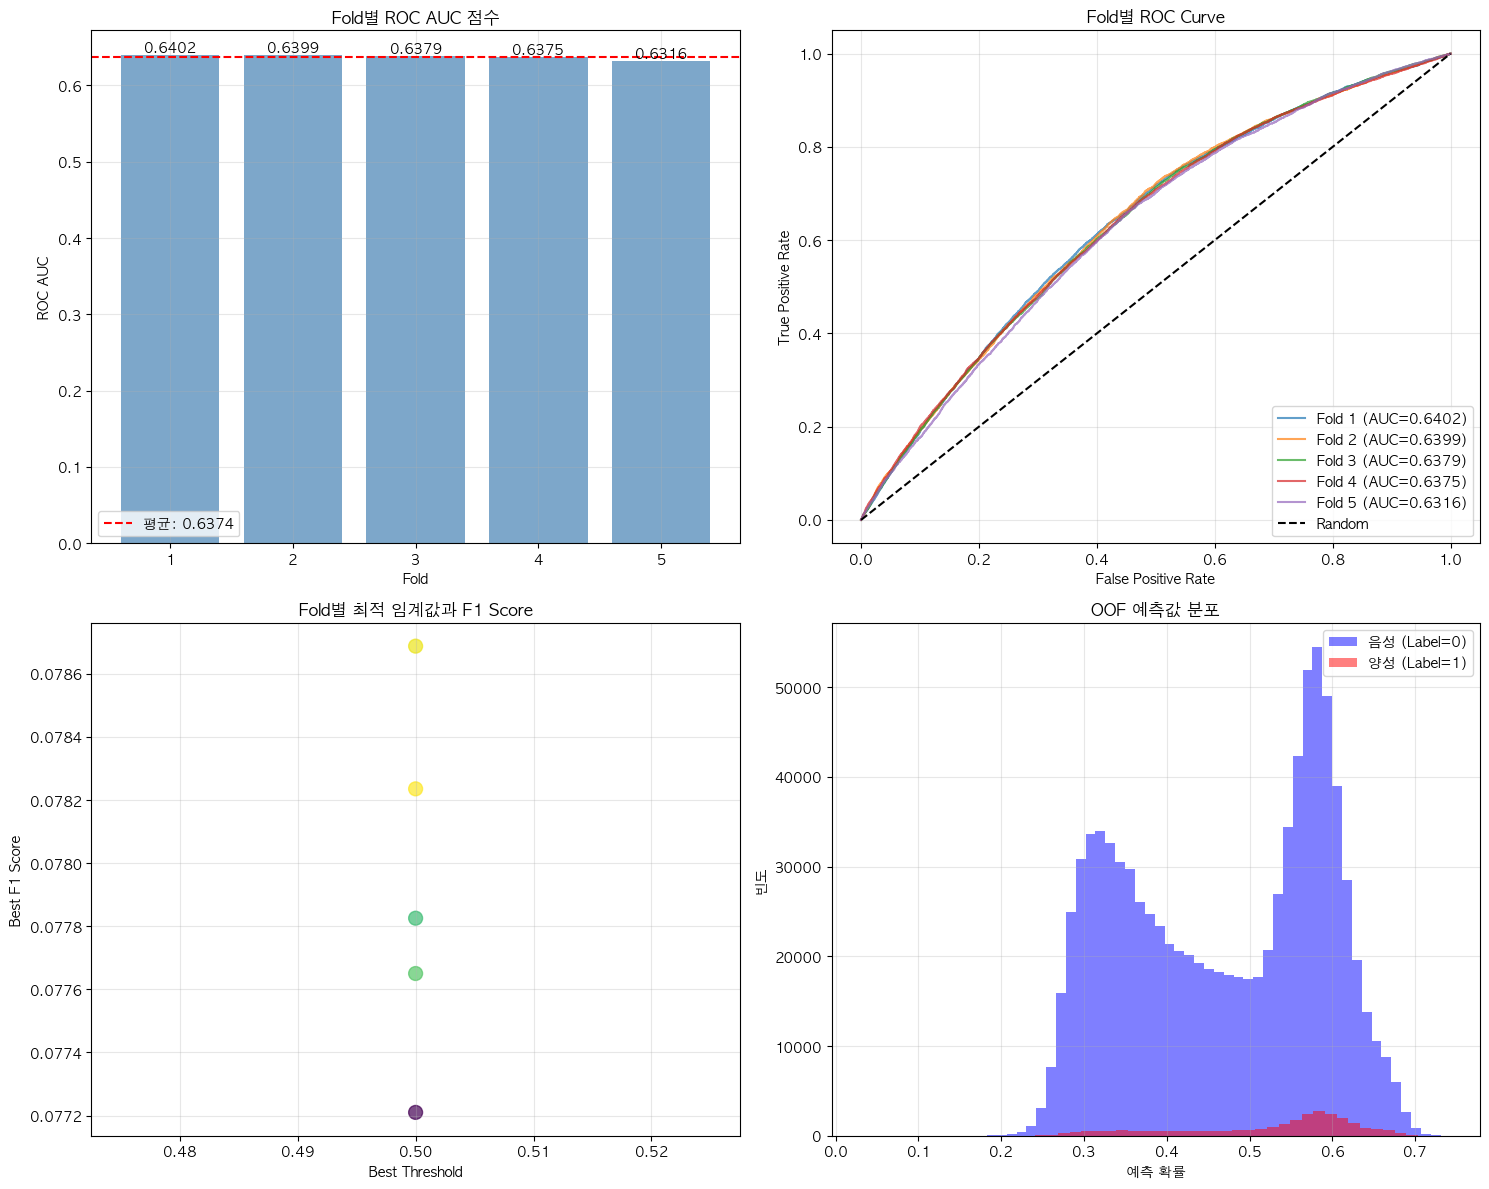

✅ 시각화 저장: ../output/figures/cv_analysis.png


In [8]:
# 4-1. Fold별 AUC 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# AUC 막대 그래프
ax = axes[0, 0]
bars = ax.bar(cv_results['fold'], cv_results['auc'], color='steelblue', alpha=0.7)
ax.axhline(cv_results['auc'].mean(), color='red', linestyle='--', label=f'평균: {cv_results["auc"].mean():.4f}')
ax.set_xlabel('Fold')
ax.set_ylabel('ROC AUC')
ax.set_title('Fold별 ROC AUC 점수')
ax.legend()
ax.grid(True, alpha=0.3)

# 값 표시
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom')

# ROC Curves
ax = axes[0, 1]
for data in roc_curves_data:
    ax.plot(data['fpr'], data['tpr'], 
            label=f"Fold {data['fold']} (AUC={data['auc']:.4f})", alpha=0.7)
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Fold별 ROC Curve')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Threshold별 F1 Score
ax = axes[1, 0]
ax.scatter(cv_results['best_threshold'], cv_results['best_f1'], 
           s=100, c=cv_results['auc'], cmap='viridis', alpha=0.7)
ax.set_xlabel('Best Threshold')
ax.set_ylabel('Best F1 Score')
ax.set_title('Fold별 최적 임계값과 F1 Score')
ax.grid(True, alpha=0.3)

# OOF Prediction 분포
ax = axes[1, 1]
ax.hist(oof_predictions[y==0], bins=50, alpha=0.5, label='음성 (Label=0)', color='blue')
ax.hist(oof_predictions[y==1], bins=50, alpha=0.5, label='양성 (Label=1)', color='red')
ax.set_xlabel('예측 확률')
ax.set_ylabel('빈도')
ax.set_title('OOF 예측값 분포')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/cv_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 시각화 저장: ../output/figures/cv_analysis.png")

## 5. 결과 저장

In [9]:
# CV 결과 저장
cv_results.to_csv('../output/cv_fold_metrics.csv', index=False)
print("✅ CV 결과 저장: ../output/cv_fold_metrics.csv")

# OOF 예측값 저장
oof_df = pd.DataFrame({
    'Test_id': train_features['Test_id'],
    'True_Label': y,
    'OOF_Prediction': oof_predictions
})
oof_df.to_csv('../output/oof_predictions.csv', index=False)
print("✅ OOF 예측 저장: ../output/oof_predictions.csv")

# 모델 저장
import pickle
with open('../output/models/cv_models.pkl', 'wb') as f:
    pickle.dump(fold_models, f)
print("✅ CV 모델 저장: ../output/models/cv_models.pkl")

✅ CV 결과 저장: ../output/cv_fold_metrics.csv
✅ OOF 예측 저장: ../output/oof_predictions.csv
✅ CV 모델 저장: ../output/models/cv_models.pkl
✅ OOF 예측 저장: ../output/oof_predictions.csv
✅ CV 모델 저장: ../output/models/cv_models.pkl


## 6. 인사이트 및 결론

### 주요 발견
1. **모델 안정성**: CV 표준편차가 낮아 모델이 안정적으로 학습됨
2. **OOF Score**: 단일 validation 대비 더 신뢰할 수 있는 일반화 성능 지표
3. **임계값 최적화**: 폴드마다 최적 임계값이 다르므로, 앙상블 시 주의 필요

### 다음 단계
- Feature Importance 분석으로 주요 피처 식별
- 다중 모델 Stacking으로 성능 개선
- Test 데이터에 CV 평균 예측 적용